# Underactuated cartpole control with iLQR, MPPI
This example shows model predictive control to swing up the underactuated cartpole.

![Underactuated cartpole control with iLQR](./cartpole-ilqr.gif)

## Problem

**Model.** The "cartpole" is a free pendulum on a linear cart.  The input to the system is a force on the cart $f$.

$$
m l \ddot{p} \cos(\theta) + m l^2 \ddot{\theta} - m g l \sin(\theta) = 0 \\
(m + m_c) \ddot{p} + m l \ddot{\theta} \cos(\theta) - m l \dot{\theta}^2 \sin(\theta) = f
$$

where $\theta = 0$ is the angle of the pendulum when completely upright, and $p$ is the position of the cart.  The state of the system is $x = (p, \theta, \dot{p}, \dot{\theta})^\top$.  Parameters are the mass of the pendulum at the tip $m = 0.15$ kg, length of the pendulum $l = 0.75$ m, acceleration due to gravity $g = 9.8$ m/s , and the mass of the cart $m_c=1$ kg.

**Control.** The objective is to move the cart so that the pendulum will stand up vertically.  This is a classic controls and RL problem and is a typical benchmark test for new algorithms.  We use the quadratic cost function

$$
J = \sum_{i=1}^{N} x_i^\top Q x_i + \sum_{i=1}^{N-1} r u_i^2
$$

where $Q = \text{diag}(1.25, 6, 12, 0.25)$ is chosen to drive the system states 0, and the penalty $r = 0.01$ tradeoffs the input magnitude.

**Comparison to MPPI.**  The video above shows iLQR which works well for this problem.  Examining MPPI (sampling-based control) in the video below, the algorithm finds a control that achieves the desired swing up behavior using noise.  Note that due to stochastic nature of the algorithm, a solution is not always found.

![Underactuated cartpole control with MPPI](./cartpole-mppi.gif)

## Example

To run the example, build and install the C++ and Python libraries from the main README instructions.  Start the docker container.
```
# Run the experiment
cd /libsia/bin
./example-cartpole --datafile /libsia/data/cartpole.csv --algorithm ilqr

# Run the python script
cd /libsia/examples/cartpole
python cartpole.py --help
python cartpole.py --datafile /libsia/data/cartpole.csv
```

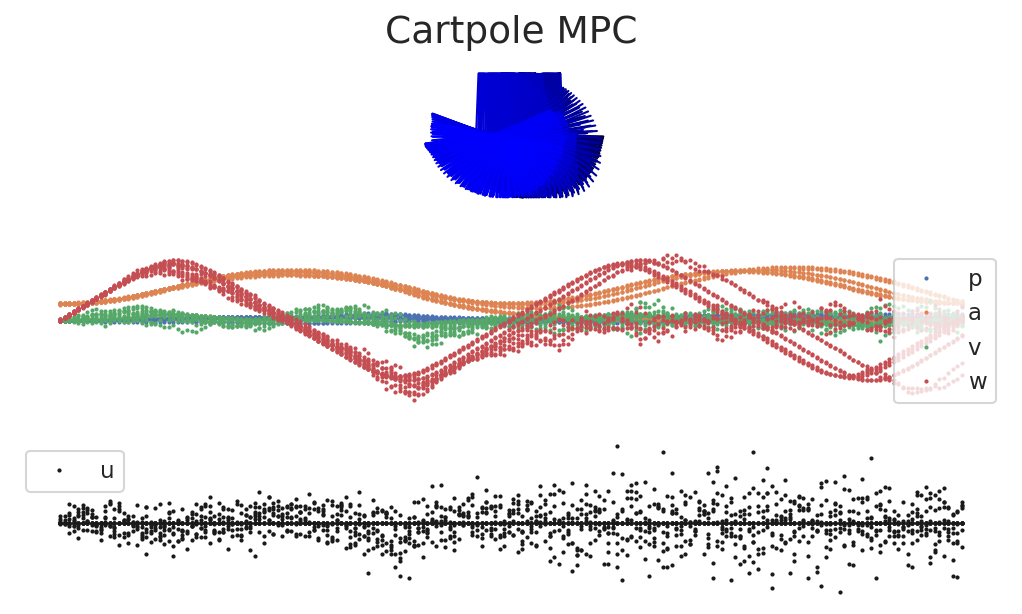

In [37]:
# This example imports data generated by the executable
from cartpole import plot_cartpole_trajectory

# This is the same as running the python script
plot_cartpole_trajectory(datafile="/libsia/data/cartpole.csv",
                         animate=False,
                         trace=True,
                         video_name="cartpole-animated.mp4",
                         dpi=150,
                         fps=30,
                         clean_axes=True)

## Running a single trial

## Data collection from multiple demonstrations

Running case /libsia/data/cartpole-0.csv
Running case /libsia/data/cartpole-1.csv
Running case /libsia/data/cartpole-2.csv
Running case /libsia/data/cartpole-3.csv
Running case /libsia/data/cartpole-4.csv
Running case /libsia/data/cartpole-5.csv
Running case /libsia/data/cartpole-6.csv
Running case /libsia/data/cartpole-7.csv
Running case /libsia/data/cartpole-8.csv
Running case /libsia/data/cartpole-9.csv
Running case /libsia/data/cartpole-10.csv
Running case /libsia/data/cartpole-11.csv
Running case /libsia/data/cartpole-12.csv
Running case /libsia/data/cartpole-13.csv
Running case /libsia/data/cartpole-14.csv
Running case /libsia/data/cartpole-15.csv
Running case /libsia/data/cartpole-16.csv
Running case /libsia/data/cartpole-17.csv
Running case /libsia/data/cartpole-18.csv
Running case /libsia/data/cartpole-19.csv
(4, 3980)
(1, 3980)
(4, 3980)
GMR Dynamics MSE 0.0007679787230315619


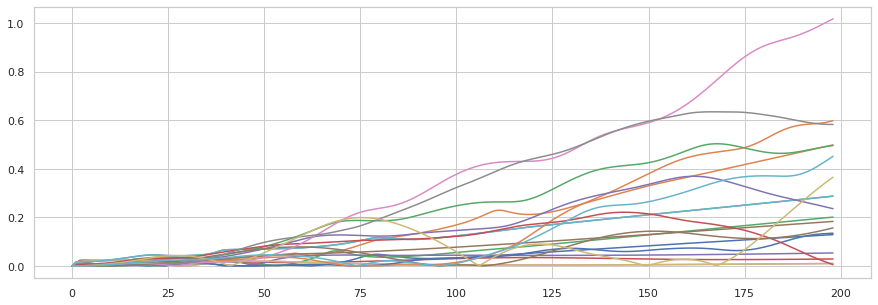

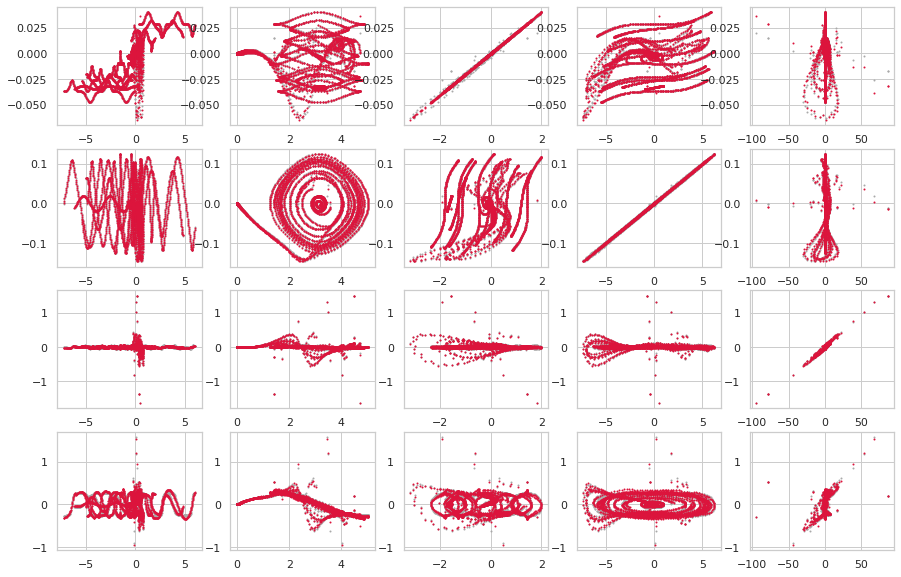

In [34]:
import subprocess
import pandas as pd
import numpy as np
import pysia as sia

# Seed the RNG
generator = sia.Generator.instance()
generator.seed(3)

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

num_trials = 20
num_steps = 200
algorithm = "ilqr"
init_case = "coarse"
datafiles = ["/libsia/data/cartpole-{}.csv".format(i) for i in range(num_trials)]

# Peform n trials with an expert policy
df = pd.DataFrame()
trajs = {}
i = 0
for datafile in datafiles:
    print("Running case {}".format(datafile))
#     subprocess.call(["/libsia/bin/example-cartpole",
#                      "--num_steps",
#                      str(num_steps),
#                      "--algorithm",
#                      algorithm,
#                      "--init_case",
#                      init_case,
#                      "--measurement_noise",
#                      "1e-12",
#                      "--process_noise",
#                      "1e-12",
#                      "--datafile",
#                      datafile])

    df = pd.read_csv(datafile)
    D = df[["p", "a", "v", "w", "f"]].to_numpy()
    if i == 0:
        Xk = D[:-1, :4].T
        Uk = D[:-1, 4:].T
        Xkp1 = D[1:, :4].T
    else:
        Xk = np.hstack((Xk, D[:-1, :4].T))
        Uk = np.hstack((Uk, D[:-1, 4:].T))
        Xkp1 = np.hstack((Xkp1, D[1:, :4].T))
    trajs[i] = (D[:-1, :4].T, D[:-1, 4:].T)
    i += 1
XkUk = np.vstack((Xk, Uk))

print(np.shape(Xk))
print(np.shape(Uk))
print(np.shape(Xkp1))

# Generate a model
model = sia.GMRDynamics(Xk=Xk, Uk=Uk, Xkp1=Xkp1, K=20, regularization=1e-2)
print("GMR Dynamics MSE {}".format(model.mse(Xk=Xk, Uk=Uk, Xkp1=Xkp1)))

# Predict the training points
Xkp1_pred = np.zeros(np.shape(Xkp1))
for i in range(np.shape(Xkp1_pred)[1]):
    Xkp1_pred[:, i] = model.f(Xk[:, i], Uk[:, i])
    

# Predict the multi-step prediction error
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5), num=1)
for traj in trajs.values():
    X = traj[0]
    U = traj[1]
    Xhat = np.zeros(np.shape(X))
    Xhat[:, 0] = X[:, 0]
    for k in range(num_steps - 2):
        Xhat[:, k+1] = model.f(Xhat[:, k], U[:, k])
    error = np.abs(Xhat[0, :] - X[0, :])
    ax.plot(error.T)
    

# Plot the correlation data
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15, 10), num=2)
for i in range(4):
    for j in range(5):
        ax[i, j].scatter(XkUk[j, :], Xkp1[i, :] - Xk[i, :], s=1, color="darkgray")
        ax[i, j].scatter(XkUk[j, :], Xkp1_pred[i, :] - Xk[i, :], s=1, color="crimson")
#         for gaussian in model.gmr().gmm().gaussians():
#             mean = gaussian.mean()
#             covariance = gaussian.covariance()
#             ax[i, j].plot(mean[j], mean[5+i], 'ro', ms=7)
#         ax[i, j].axis("off")

Idea:
- [Model improvements] Weight the data points with higher magnitude accelerations so that the GMM fits accordingly.  The intuition here is that higher accelerations will have fewer data points and thus be missed in the fit when instead this is right where some critical dynamics lie.
- [Model improvements] Train the model by minimizing the multi-step error rather than the single-step error.
- [Seed improvements] Learn a policy regression, this is not stabilizing but could be a good seed for the MPC.  The intuition here is that a seed of $\{0\}$ is not a good initializer because it is not inside the training domain.  Perhaps to test this theory, augment the training data with examples of no input and see what happens.
  - Attempted bootstrap with $\{0\}$ cases, interesting result: the MPC policy using the learned model looks very similar to the dynamics with $\{0\}$ cases.  iLQR starts with a bang (probably multi-step error) but quickly goes to 0.  MPPI is noisy but seems the average is zero.
  - It seems the initial policy is too far from the solution, but how could this be?  The solution is not much different, there are just a few extra wiggles to lift the pole.  Are these dynamics not captured?

## Model-based Reinforcement Learning